In [1]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 20.4MB/s 
     |████████████████████████████████| 7.6MB 7.2MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
from os.path import exists

In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import PIL
print(PIL.__version__)

7.0.0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [8]:
!unzip -q /content/gdrive/MyDrive/kt_vmg_train.zip -d train
!unzip -q /content/gdrive/MyDrive/kt_vmg_val.zip -d val

Выходные данные были обрезаны до нескольких последних строк (5000).
kt_vmg_train/ВМГ отсутствует/3D_MPR_-_SHITOV_V.T.‎_(76y)_-_24.10.2020_11_35_37_-_soft_0039.jpg:  mismatching "local" filename (kt_vmg_train/╨Т╨Ь╨У ╨╛╤В╤Б╤Г╤В╤Б╤В╨▓╤Г╨╡╤В/3D_MPR_-_SHITOV_V.T.тАО_(76y)_-_24.10.2020_11_35_37_-_soft_0039.jpg),
         continuing with "central" filename version
kt_vmg_train/ВМГ отсутствует/3D_MPR_-_SHITOV_V.T.‎_(76y)_-_24.10.2020_11_35_37_-_soft_0040.jpg:  mismatching "local" filename (kt_vmg_train/╨Т╨Ь╨У ╨╛╤В╤Б╤Г╤В╤Б╤В╨▓╤Г╨╡╤В/3D_MPR_-_SHITOV_V.T.тАО_(76y)_-_24.10.2020_11_35_37_-_soft_0040.jpg),
         continuing with "central" filename version
kt_vmg_train/ВМГ отсутствует/3D_MPR_-_SHITOV_V.T.‎_(76y)_-_24.10.2020_11_35_37_-_soft_0041.jpg:  mismatching "local" filename (kt_vmg_train/╨Т╨Ь╨У ╨╛╤В╤Б╤Г╤В╤Б╤В╨▓╤Г╨╡╤В/3D_MPR_-_SHITOV_V.T.тАО_(76y)_-_24.10.2020_11_35_37_-_soft_0041.jpg),
         continuing with "central" filename version
kt_vmg_train/ВМГ отсутствует/3D_MPR_-_SHITOV_V.T.‎_(76y)

In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Jan 26 14:13:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [13]:
unlabeler = LabelEncoder()
labels = [path.parent.name for path in train_files]
unlabeler.fit(labels)
with open('label_vmg_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(unlabeler, le_dump_file)

In [14]:
class KTDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = encoder

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.crop((470, 0, 1449, 979))
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
import random

In [11]:
TRAIN_DIR = Path('train/kt_vmg_train')
train_files = list(TRAIN_DIR.rglob('*.jpg'))
random.shuffle(train_files)
print(train_files)

[PosixPath('train/kt_vmg_train/ВМГ отсутствует/3D_MPR_-_Borodina_Aljbina_A.\u200e_(81y)_-_26.09.2020_9_43_01_-__Head_0.5_0289.jpg'), PosixPath('train/kt_vmg_train/ВМГ отсутствует/3D_MPR_-_Ponomaryov_V.A.\u200e_(51y)_-_24.09.2020_16_03_54_-__Head_0.5_0021.jpg'), PosixPath('train/kt_vmg_train/ВМГ консерва/3D_MPR_-_DULJTZEV_A_A\u200e_(56y)_-_26.10.2020_19_39_12_-__Head_0.5_0028.jpg'), PosixPath('train/kt_vmg_train/ВМГ консерва/3D_MPR_-_PONOMAREVA__A_M\u200e_(86y)_-_10.10.2020_2_27_07_-_Head__1.5__J30s_0054.jpg'), PosixPath('train/kt_vmg_train/ВМГ консерва/3D_MPR_-_LEVINA_L_G\u200e_(48y)_-_01.10.2020_14_34_43_-__Head_0.5_0100.jpg'), PosixPath('train/kt_vmg_train/ВМГ консерва/3D_MPR_-_Zolotaryov_S.P.\u200e_(67y)_-_20.09.2020_22_49_18_-__Head_0.5_0049.jpg'), PosixPath('train/kt_vmg_train/ВМГ задняя яма/3D_MPR_-_DIDEVICH_E.YU.\u200e_(59y)_-_04.10.2020_16_31_28_-__Head_0.5____Vol._0075.jpg'), PosixPath('train/kt_vmg_train/ВМГ отсутствует/3D_MPR_-_YUMAKOV_V_I\u200e_(62y)_-_22.10.2020_19_39_04_-

In [12]:
VAL_DIR = Path('val/kt_vmg_val')
val_files=list(VAL_DIR.rglob('*.jpg'))
random.shuffle(val_files)
print(val_files)

[PosixPath('val/kt_vmg_val/ВМГ отсутствует/3D_MPR_-_ANTIPOVA_V.N.\u200e_(75y)_-_09.10.2020_7_24_01_-_SFT_0.625_0103.jpg'), PosixPath('val/kt_vmg_val/ВМГ задняя яма/3D_MPR_-_BORISOVA_V.I_KORP1\u200e_(82y)_-_28.09.2020_10_44_00_-_HEAD_STAND__1.5__H31s_0057.jpg'), PosixPath('val/kt_vmg_val/ВМГ отсутствует/3D_MPR_-_BEZNOSOV_V_F\u200e_(69y)_-_15.10.2020_10_47_44_-_Head__1.5__J30s_0106.jpg'), PosixPath('val/kt_vmg_val/ВМГ отсутствует/3D_MPR_-_BEZNOSOV_V_F\u200e_(69y)_-_15.10.2020_10_47_44_-_Head__1.5__J30s_0082.jpg'), PosixPath('val/kt_vmg_val/ВМГ отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0039.jpg'), PosixPath('val/kt_vmg_val/ВМГ отсутствует/3D_MPR_-_ANTIPOVA_V.N.\u200e_(75y)_-_09.10.2020_7_24_01_-_SFT_0.625_0057.jpg'), PosixPath('val/kt_vmg_val/ВМГ отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0051.jpg'), PosixPath('val/kt_vmg_val/ВМГ консерва/3D_MPR_-_KABIEVA_A\u200e_(81y)_-_02.10.2020_20_46_25_-__Head_0.5_0116.jpg')

In [16]:
val_dataset = KTDataset(val_files, mode='val', encoder=unlabeler)
print(len(val_dataset))

260


In [17]:
train_dataset = KTDataset(train_files, mode = 'train', encoder=unlabeler)

In [18]:
print(len(train_files))

9865


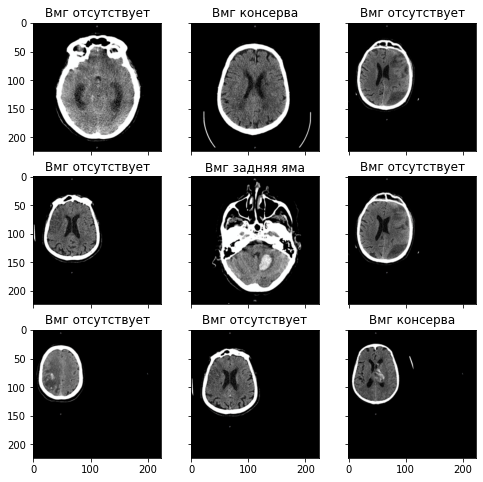

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,260))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [20]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [21]:
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [22]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [23]:
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [24]:
from torchvision import datasets, models, transforms

num_classes=4
torch.manual_seed(42)
np.random.seed(42)

base_model=SimpleCnn(num_classes)

base_model=base_model.to(DEVICE)

# loss_fn = f1_loss

# optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-2)

# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [26]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [27]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            torch.save(model.state_dict(), "gdrive/MyDrive/KT_vmg_"+str(epoch+1)+".pth")
    return history

In [28]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [29]:
print(base_model)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=4, bias=True)
)

In [ ]:
history = train(train_dataset, val_dataset, model=base_model, epochs=15, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.818263609664306


epoch:   7%|▋         | 1/15 [03:56<55:13, 236.66s/it]


Epoch 001 train_loss: 0.8183     val_loss 0.6663 train_acc 0.6068 val_acc 0.7885
loss 0.20044288638463736


epoch:  13%|█▎        | 2/15 [07:50<51:07, 235.92s/it]


Epoch 002 train_loss: 0.2004     val_loss 0.0941 train_acc 0.9279 val_acc 0.9654
loss 0.06695765684127715


epoch:  20%|██        | 3/15 [11:44<47:03, 235.30s/it]


Epoch 003 train_loss: 0.0670     val_loss 0.3367 train_acc 0.9766 val_acc 0.8038
loss 0.04249472857291966


epoch:  27%|██▋       | 4/15 [15:38<43:03, 234.82s/it]


Epoch 004 train_loss: 0.0425     val_loss 0.3281 train_acc 0.9868 val_acc 0.7962
loss 0.03584058316787011


epoch:  33%|███▎      | 5/15 [19:32<39:05, 234.58s/it]


Epoch 005 train_loss: 0.0358     val_loss 0.0845 train_acc 0.9896 val_acc 0.9577
loss 0.034498073277759916


epoch:  40%|████      | 6/15 [23:25<35:07, 234.14s/it]


Epoch 006 train_loss: 0.0345     val_loss 0.2012 train_acc 0.9885 val_acc 0.9000
loss 0.02550052977195392


epoch:  47%|████▋     | 7/15 [27:19<31:12, 234.03s/it]


Epoch 007 train_loss: 0.0255     val_loss 1.5051 train_acc 0.9909 val_acc 0.7423
loss 0.021708121343003185


epoch:  53%|█████▎    | 8/15 [31:12<27:17, 233.90s/it]


Epoch 008 train_loss: 0.0217     val_loss 0.5966 train_acc 0.9918 val_acc 0.7808
loss 0.022906252729163155


epoch:  60%|██████    | 9/15 [35:07<23:24, 234.04s/it]


Epoch 009 train_loss: 0.0229     val_loss 0.5605 train_acc 0.9928 val_acc 0.7615
loss 0.024605260008225736


epoch:  67%|██████▋   | 10/15 [38:59<19:27, 233.51s/it]


Epoch 010 train_loss: 0.0246     val_loss 0.4128 train_acc 0.9919 val_acc 0.8308
loss 0.0182796330242407


epoch:  73%|███████▎  | 11/15 [42:51<15:32, 233.13s/it]


Epoch 011 train_loss: 0.0183     val_loss 0.1928 train_acc 0.9945 val_acc 0.8654


epoch:  73%|███████▎  | 11/15 [43:47<15:55, 238.86s/it]


KeyboardInterrupt: ignored

In [30]:
base_model.load_state_dict(torch.load("gdrive/MyDrive/KT_vmg_4.pth", map_location=torch.device('cpu')))

RuntimeError: ignored

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [32]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [33]:
random_characters = int(np.random.uniform(0,260))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(base_model, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)

In [37]:
print(probs_ims)

[[0.15462804 0.10005738 0.6800643  0.06525023]
 [0.7760848  0.11182143 0.10696509 0.00512879]
 [0.6147314  0.2661144  0.11459278 0.00456147]
 [0.10836796 0.10571036 0.707685   0.07823665]
 [0.02514776 0.9679116  0.00318644 0.00375431]
 [0.12462903 0.8397885  0.03445984 0.00112259]
 [0.07140977 0.20955603 0.6242051  0.09482911]
 [0.25528568 0.4916489  0.2413411  0.01172443]
 [0.6075418  0.26628023 0.11878628 0.00739166]
 [0.29099894 0.26455286 0.43636245 0.00808575]
 [0.39408317 0.42221057 0.17076473 0.01294152]
 [0.61673856 0.25581414 0.12006544 0.00738179]
 [0.10036526 0.20402966 0.61990523 0.07569984]
 [0.29957837 0.5029679  0.18434745 0.01310632]
 [0.97477585 0.01760163 0.00446857 0.00315391]
 [0.6140351  0.26017228 0.11838076 0.00741188]
 [0.29957837 0.5029679  0.18434745 0.01310632]
 [0.05991716 0.91797674 0.02068399 0.0014222 ]
 [0.12180303 0.58591574 0.21170762 0.08057356]
 [0.10836796 0.10571036 0.707685   0.07823665]
 [0.73871213 0.14247957 0.11296178 0.00584659]
 [0.6038019  

In [39]:
label_encoder = pickle.load(open("label_vmg_encoder.pkl", 'rb'))

In [40]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [41]:
actual_labels=[label_encoder.classes_[i] for i in actual_labels]
print(actual_labels)
print(y_pred)
print(preds_class)

['ВМГ консерва', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ консерва', 'ВМГ задняя яма', 'ВМГ отсутствует', 'ВМГ консерва', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ консерва', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ консерва', 'ВМГ консерва', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ задняя яма', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ консерва', 'ВМГ консерва', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ под операцию', 'ВМГ под операцию', 'ВМГ консерва', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ задняя яма', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ задняя яма', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ консерва', 'ВМГ консерва', 'ВМГ отсутствует', 'ВМГ под операцию', 'ВМГ консерва', 'ВМГ отсутствует', 'ВМГ отсутствует', 'ВМГ консерва', 'ВМГ отсутств

In [42]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average=None)


array([0.        , 0.24242424, 0.25263158, 0.        ])

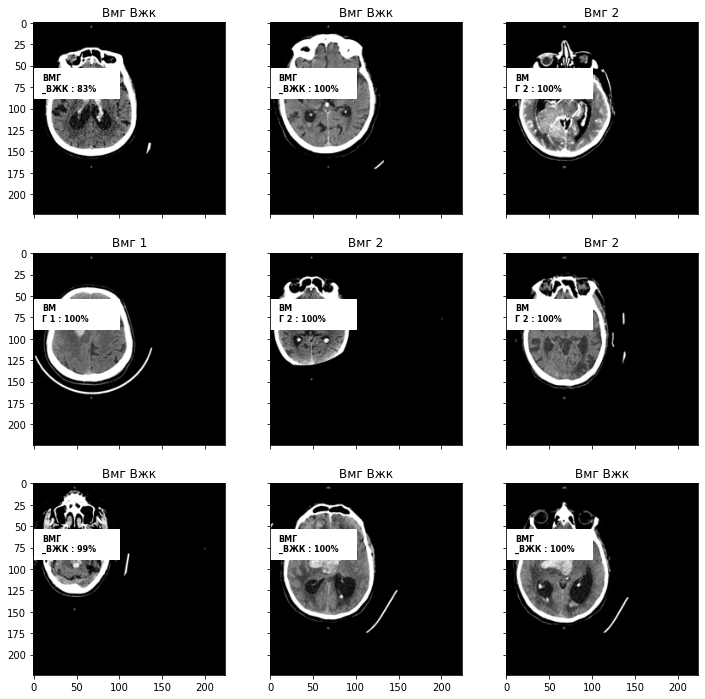

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2808))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
torch.save(base_model.state_dict(), "gdrive/MyDrive/KT_base_v2_last.pth")

In [ ]:
def predict_picture(file_name):
    TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

    test_files = list(TEST_DIR.rglob(file_name))

    test_dataset = KTDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(base_model, test_loader)
    print(probs)
    predicted_proba = np.max(probs)*100
    for i in range(len(probs[0])):
      print(probs[0][i]*100, label_encoder.classes_[i])
    y_pred = np.argmax(probs)
    predicted_label = label_encoder.classes_[y_pred]
    return predicted_label, predicted_proba

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
print(predict_picture("10.jpg"))

[[2.3849365e-05 7.8634754e-02 9.4841748e-02 3.5471048e-02 3.6185865e-09
  9.6606191e-06 1.3273510e-01 2.4622777e-03 3.6915779e-08 1.2144416e-04
  3.2435180e-04 4.2660564e-02 6.1262834e-01 8.6691303e-05]]
0.0023849364879424684 ВЖК
7.8634753823280334 ВМГ 1
9.484174847602844 ВМГ 2
3.5471048206090927 ВМГ_ВЖК
3.6185865415205853e-07 ВМГ_ВЖК_САК
0.0009660619070928078 ВМГ_ВЖК_ишем
13.273510336875916 ВМГ_ишемия
0.24622776545584202 САК
3.6915778878210403e-06 САК_ВЖК
0.01214441581396386 САК_ВМГ
0.03243518003728241 СД
4.266056418418884 ишемия
61.26283407211304 опухоль
0.008669130329508334 эд_сд
('опухоль', 61.26283407211304)


In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

val_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
print(val_files)

[PosixPath('/content/gdrive/MyDrive/kt_test_fold/2.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/3.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/1.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/4.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/5.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/6.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/7.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/8.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/9.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/10.jpg')]


In [ ]:
val_dataset = KTDataset(val_files, mode='val')

In [ ]:
print(len(val_dataset))

10


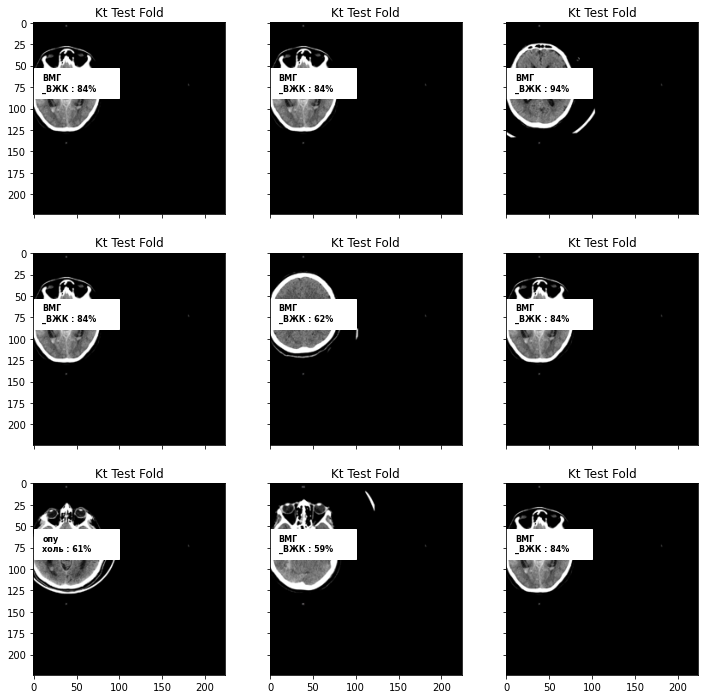

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

test_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
test_dataset = KTDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(base_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [ ]:
print(preds)

['ВМГ_ВЖК' 'опухоль' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ 2'
 'ишемия' 'ВМГ_ВЖК' 'ВМГ_ВЖК']


In [ ]:
TRAIN_DIR = Path('train/Готовые снимки')
# TEST_DIR = Path('test/kt_test_data_test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
random.shuffle(train_val_files)
print(train_val_files)
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))